# Analyse du Modèle TAIL-MIL

Ce notebook permet de charger un modèle TAIL-MIL pré-entraîné et de visualiser les poids d'attention (temporelle et par variable). Cela aide à comprendre quelles parties du signal et quelles variables le modèle utilise pour prendre sa décision.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Ajout du dossier courant au path pour importer les modules locaux
sys.path.append(os.getcwd())

from dataset import UnifiedCElegansDataset
from models.model_tail_mil import TAIL_MIL, ScaledDataset, compute_stats

# Configuration de l'affichage
%matplotlib inline
sns.set_theme(style="whitegrid")

In [2]:
# --- Configuration ---

# Chemin vers le modèle pré-entraîné
# Assurez-vous que ce fichier existe. Sinon, ajustez le chemin (ex: "tail_mil/tail_mil_worm_best.pth")
MODEL_PATH = "ckpts/best_model.pth" 

# Dossier contenant les données pré-traitées pour PyTorch
PYTORCH_DATA_DIR = "preprocessed_data/"

# Paramètres du modèle (doivent correspondre à ceux utilisés lors de l'entraînement)
# D'après main_pipeline.py : embed_dim=32
EMBED_DIM = 16 
SEGMENT_LEN = 900 # Valeur par défaut dans dataset.py

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# --- Chargement des Données et du Modèle ---

# 1. Chargement du Dataset
print("Chargement du dataset...")
raw_dataset = UnifiedCElegansDataset(pytorch_dir=PYTORCH_DATA_DIR, segment_len=SEGMENT_LEN)
worm_ids = raw_dataset.get_worm_ids_for_pytorch()
print(f"Dataset brut chargé : {len(raw_dataset)} échantillons.")

# Calcul des statistiques pour le scaling
# Note: Idéalement, on devrait utiliser les stats du train set uniquement.
# Ici, on calcule sur tout le dataset pour l'analyse.
print("Calcul des statistiques pour le scaling...")
mean, std = compute_stats(raw_dataset, range(len(raw_dataset)), batch_size=32)

# Création du dataset scalé
dataset = ScaledDataset(raw_dataset, mean, std)
print("Dataset scalé prêt.")

# 2. Chargement du Modèle
print(f"Chargement du modèle depuis {MODEL_PATH}...")
model = TAIL_MIL(segment_len=dataset.dataset.segment_len, embed_dim=EMBED_DIM).to(DEVICE)

if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("Modèle chargé avec succès.")
else:
    print(f"ERREUR : Le fichier modèle {MODEL_PATH} est introuvable.")

Chargement du dataset...
Dataset brut chargé : 104 échantillons.
Calcul des statistiques pour le scaling...
Dataset scalé prêt.
Chargement du modèle depuis ckpts/best_model.pth...
Modèle chargé avec succès.


In [4]:
def visualize_attention(worm_idx, hide_padding=True):
    """
    Exécute le modèle sur un ver donné et visualise les attentions.
    Option hide_padding: Masque les segments de padding (tous à zéro).
    """
    if worm_idx >= len(dataset):
        print(f"Index {worm_idx} hors limites.")
        return

    worm_id = worm_ids[worm_idx]
    print(f"--- Analyse du Ver ID : {worm_id} (Index: {worm_idx}) ---")

    # Récupération des données
    X, y = dataset[worm_idx]
    # X shape: (T, V, L)
    
    # Détection du padding (segments entièrement à 0)
    # On somme sur les dimensions V et L pour voir si le segment est vide
    is_padding = (X.abs().sum(dim=(1, 2)) == 0).numpy()
    non_padding_indices = np.where(~is_padding)[0]
    
    X_input = X.unsqueeze(0).to(DEVICE) # Ajout dimension batch : (1, T, V, L)

    # Inférence
    with torch.no_grad():
        y_prob, t_weights, v_weights = model(X_input)

    # Récupération des résultats
    prob = y_prob.item()
    true_label = y.item()
    pred_label = 1 if prob > 0.5 else 0
    
    print(f"Vraie Classe : {true_label} ({'TERBINAFINE+' if true_label==1 else 'Control'})")
    print(f"Probabilité Prédite : {prob:.4f}")
    print(f"Prédiction : {pred_label}")

    # --- Visualisation ---
    
    # t_weights : (1, T, 1) -> (T,)
    t_att = t_weights.squeeze().cpu().numpy()
    
    # v_weights : (1, T, V) -> (T, V)
    v_att = v_weights.squeeze().cpu().numpy()

    if hide_padding:
        # On ne garde que les indices non-padding
        t_att = t_att[non_padding_indices]
        v_att = v_att[non_padding_indices]
        print(f"Affichage de {len(non_padding_indices)} segments (padding masqué).")
    else:
        print(f"Affichage de tous les {len(t_att)} segments.")

    # Création de la figure avec alignement vertical
    # height_ratios pour donner plus de place à la heatmap
    # hspace réduit pour coller les graphiques
    fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True, gridspec_kw={'height_ratios': [1, 2], 'hspace': 0.05})

    # 1. Attention Temporelle (Bar plot)
    # align='edge' et width=1.0 pour correspondre aux cellules de la heatmap qui vont de i à i+1
    x_indices = range(len(t_att))
    axes[0].bar(x_indices, t_att, color='skyblue', width=1.0, align='edge', edgecolor="white", linewidth=0.5)
    axes[0].set_ylabel("Attention Temporelle")
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[0].set_title(f"Attention Temporelle & Par Variable - {worm_id}")
    
    # Masquer les ticks x du haut pour éviter la surcharge
    axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # 2. Attention par Variable (Heatmap)
    # Variables : X, Y, Speed (selon dataset.py par défaut)
    vars_labels = ["X", "Y", "Speed"]
    # Transposée pour avoir (Variables, Temps)
    sns.heatmap(v_att.T, cmap="viridis", yticklabels=vars_labels, ax=axes[1], cbar_kws={'label': 'Attention Variable', 'orientation': 'horizontal', 'pad': 0.15})
    
    axes[1].set_xlabel("Index du Segment")
    axes[1].set_ylabel("Variable")
    
    # S'assurer que les limites x sont les mêmes (0 à N)
    axes[1].set_xlim(0, len(t_att))

    plt.show()

    return t_att, v_att

In [5]:
# --- Sélection et Visualisation ---

# Trouver des indices pour chaque classe
# Accès aux labels (gestion du ScaledDataset)
if hasattr(dataset, 'dataset'):
    labels = dataset.dataset.pytorch_labels
else:
    labels = dataset.pytorch_labels

pos_indices = [i for i, label in enumerate(labels) if label == 1]
neg_indices = [i for i, label in enumerate(labels) if label == 0]

print(f"Nombre d'échantillons positifs (TERBINAFINE+) : {len(pos_indices)}")
print(f"Nombre d'échantillons négatifs (Control) : {len(neg_indices)}")

Nombre d'échantillons positifs (TERBINAFINE+) : 52
Nombre d'échantillons négatifs (Control) : 52


--- Analyse du Ver ID : 20240827_piworm11_2 (Index: 3) ---
Vraie Classe : 1 (TERBINAFINE+)
Probabilité Prédite : 0.7680
Prédiction : 1
Affichage de 57 segments (padding masqué).


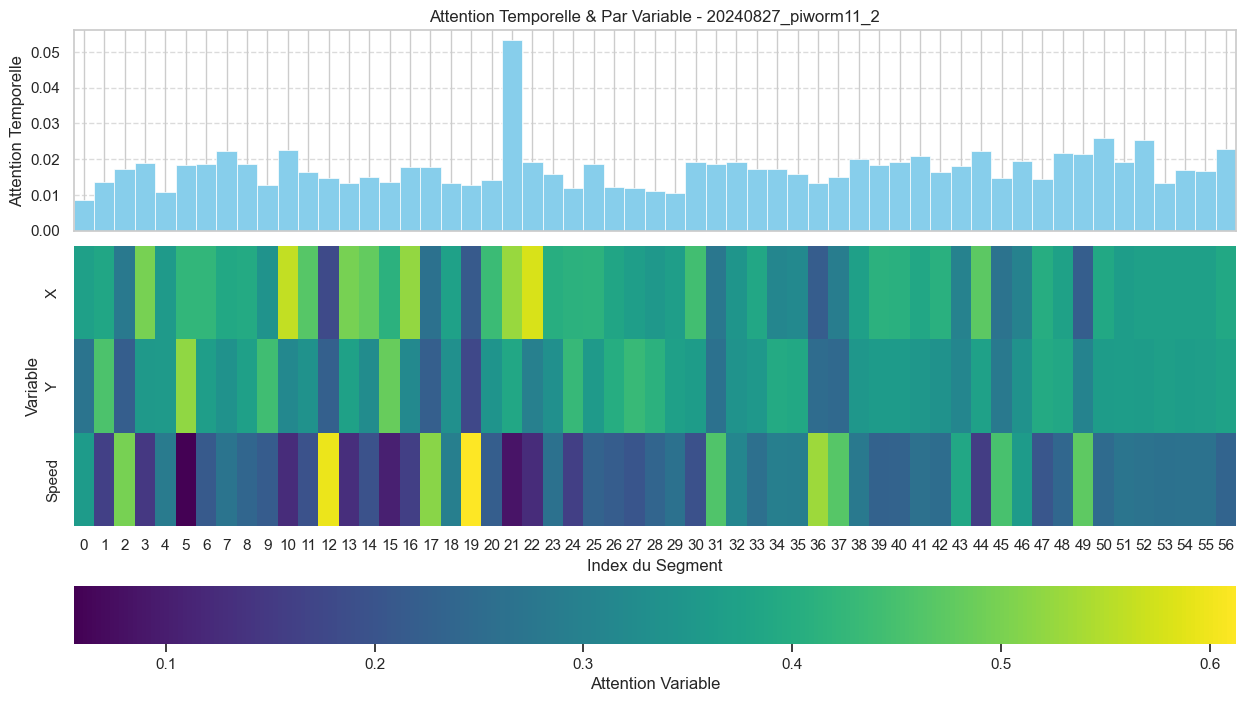

--- Analyse du Ver ID : 20240827_piworm12_4 (Index: 55) ---
Vraie Classe : 0 (Control)
Probabilité Prédite : 0.5206
Prédiction : 1
Affichage de 71 segments (padding masqué).


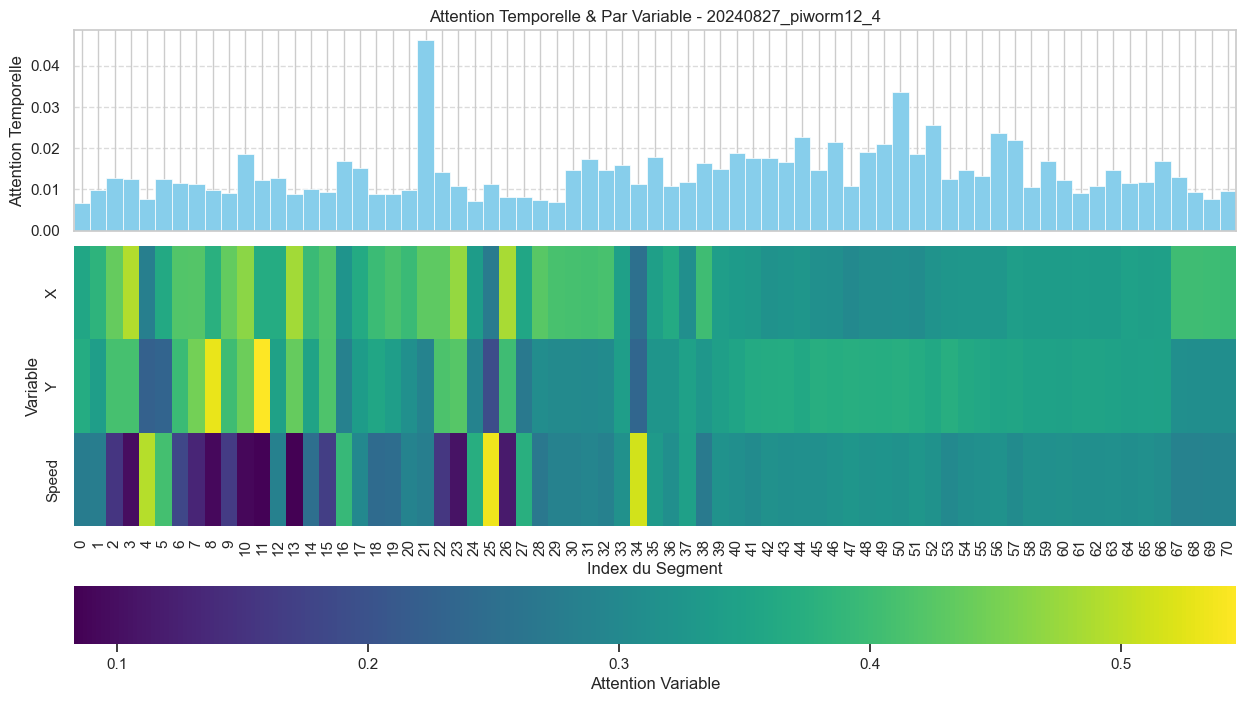

In [6]:
sample = 3
HIDE_PADDING = True

# Exemple : Visualiser le premier échantillon positif
if pos_indices:
    idx_to_plot = pos_indices[sample]
    visualize_attention(idx_to_plot, hide_padding=HIDE_PADDING)
else:
    print("Pas d'échantillons positifs trouvés.")

# Exemple : Visualiser le premier échantillon négatif
if neg_indices:
    idx_to_plot = neg_indices[sample]
    visualize_attention(idx_to_plot, hide_padding=HIDE_PADDING)
else:
    print("Pas d'échantillons négatifs trouvés.")

Calcul de la moyenne des attentions sur l'ensemble du dataset...
Précision globale sur le dataset : 75.96%
Médiane du nombre de segments : 79.5
Affichage de la moyenne des attentions et du top 5.


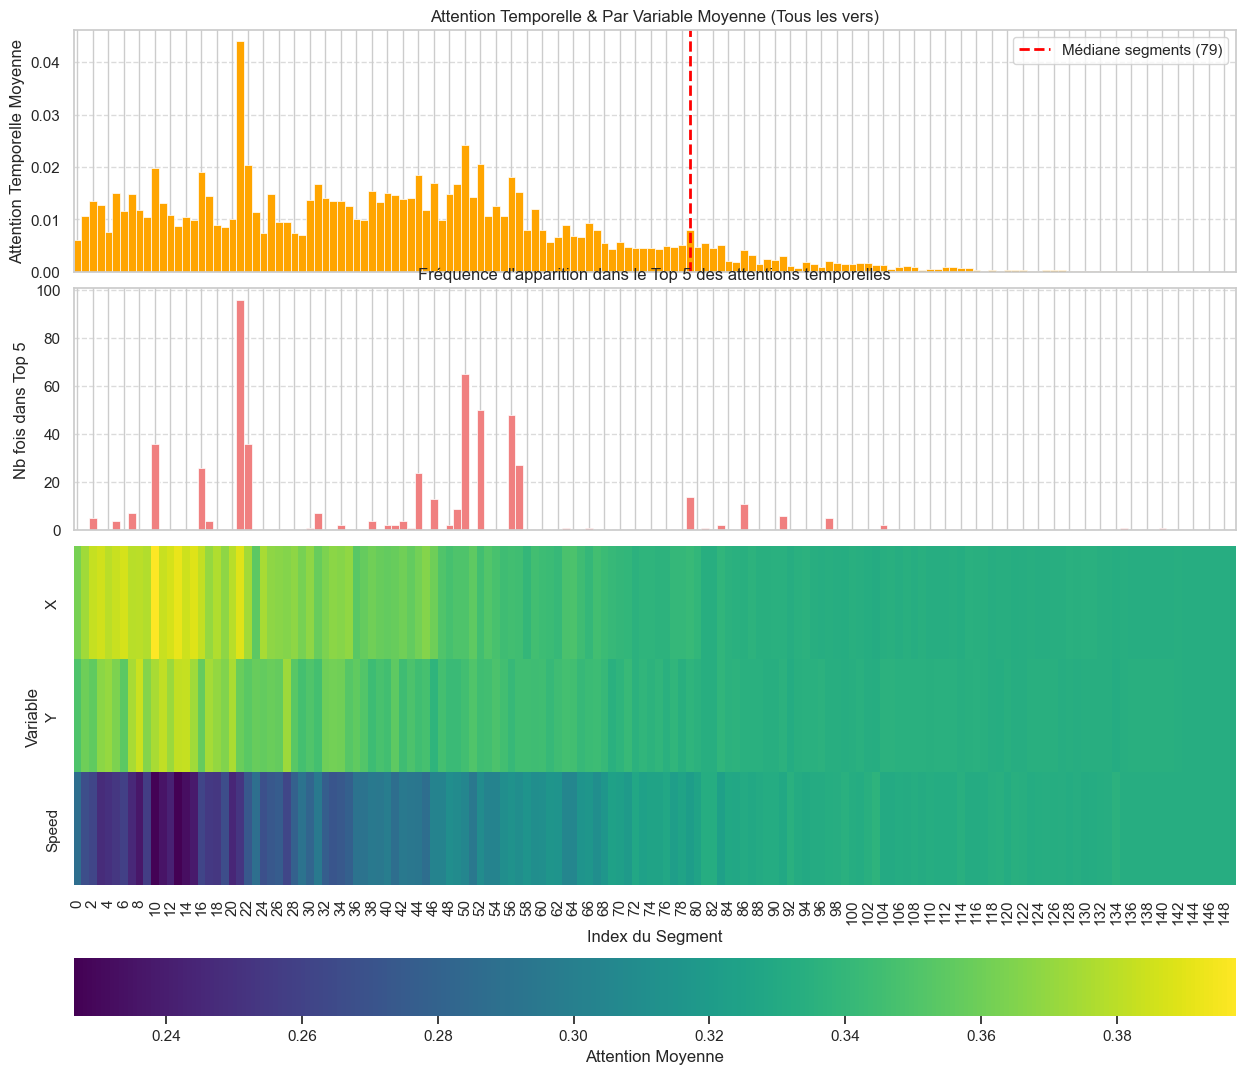

In [7]:
# --- Moyenne des Attentions sur Tous les Vers ---

print("Calcul de la moyenne des attentions sur l'ensemble du dataset...")

all_t_att = []
all_v_att = []
acc = []
lengths = []

model.eval()
with torch.no_grad():
    for i in range(len(dataset)):
        X, y = dataset[i]
        X_input = X.unsqueeze(0).to(DEVICE)
        
        # Calcul de la longueur réelle (hors padding)
        is_padding = (X.abs().sum(dim=(1, 2)) == 0).numpy()
        length = np.sum(~is_padding)
        lengths.append(length)

        # Inférence
        pred, t_weights, v_weights = model(X_input)
        prob = pred.item()
        true_label = y.item()
        pred_label = 1 if prob > 0.5 else 0
        acc.append(1 if pred_label == true_label else 0)

        # t_weights: (1, T, 1) -> (T,)
        # v_weights: (1, T, V) -> (T, V)
        all_t_att.append(t_weights.squeeze().cpu().numpy())
        all_v_att.append(v_weights.squeeze().cpu().numpy())

# Conversion en arrays numpy pour la moyenne
all_t_att = np.array(all_t_att) # Shape: (N_samples, T)
all_v_att = np.array(all_v_att) # Shape: (N_samples, T, V)
print(f"Précision globale sur le dataset : {np.mean(acc)*100:.2f}%")

# Calcul des moyennes
mean_t_att = np.mean(all_t_att, axis=0)
mean_v_att = np.mean(all_v_att, axis=0)

# Calcul de la médiane des longueurs
median_length = np.median(lengths)
print(f"Médiane du nombre de segments : {median_length}")

# --- Calcul du Top 5 des segments ---
top5_counts = np.zeros(all_t_att.shape[1])  # Pour chaque position de segment

for sample_att in all_t_att:
    # Trouver les indices des 5 plus hautes valeurs d'attention
    top5_indices = np.argsort(sample_att)[-5:]
    # Incrémenter le compteur pour ces positions
    top5_counts[top5_indices] += 1

print("Affichage de la moyenne des attentions et du top 5.")

# --- Visualisation ---
fig, axes = plt.subplots(3, 1, figsize=(15, 13), sharex=True, gridspec_kw={'height_ratios': [1, 1, 2], 'hspace': 0.05})

# 1. Attention Temporelle Moyenne
x_indices = range(len(mean_t_att))
axes[0].bar(x_indices, mean_t_att, color='orange', width=1.0, align='edge', edgecolor="white", linewidth=0.5)
axes[0].set_ylabel("Attention Temporelle Moyenne")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].set_title("Attention Temporelle & Par Variable Moyenne (Tous les vers)")
axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Ajout de la ligne verticale pour la médiane
axes[0].axvline(x=median_length, color='red', linestyle='--', linewidth=2, label=f'Médiane segments ({int(median_length)})')
axes[0].legend()

# 2. Comptage Top 5
axes[1].bar(x_indices, top5_counts, color='lightcoral', width=1.0, align='edge', edgecolor="white", linewidth=0.5)
axes[1].set_ylabel("Nb fois dans Top 5")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].set_title("Fréquence d'apparition dans le Top 5 des attentions temporelles")
axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# 3. Attention par Variable Moyenne
vars_labels = ["X", "Y", "Speed"]
sns.heatmap(mean_v_att.T, cmap="viridis", yticklabels=vars_labels, ax=axes[2], cbar_kws={'label': 'Attention Moyenne', 'orientation': 'horizontal', 'pad': 0.15})
axes[2].set_xlabel("Index du Segment")
axes[2].set_ylabel("Variable")
axes[2].set_xlim(0, len(mean_t_att))

plt.show()

Affichage des trajectoires pour 10 vers...


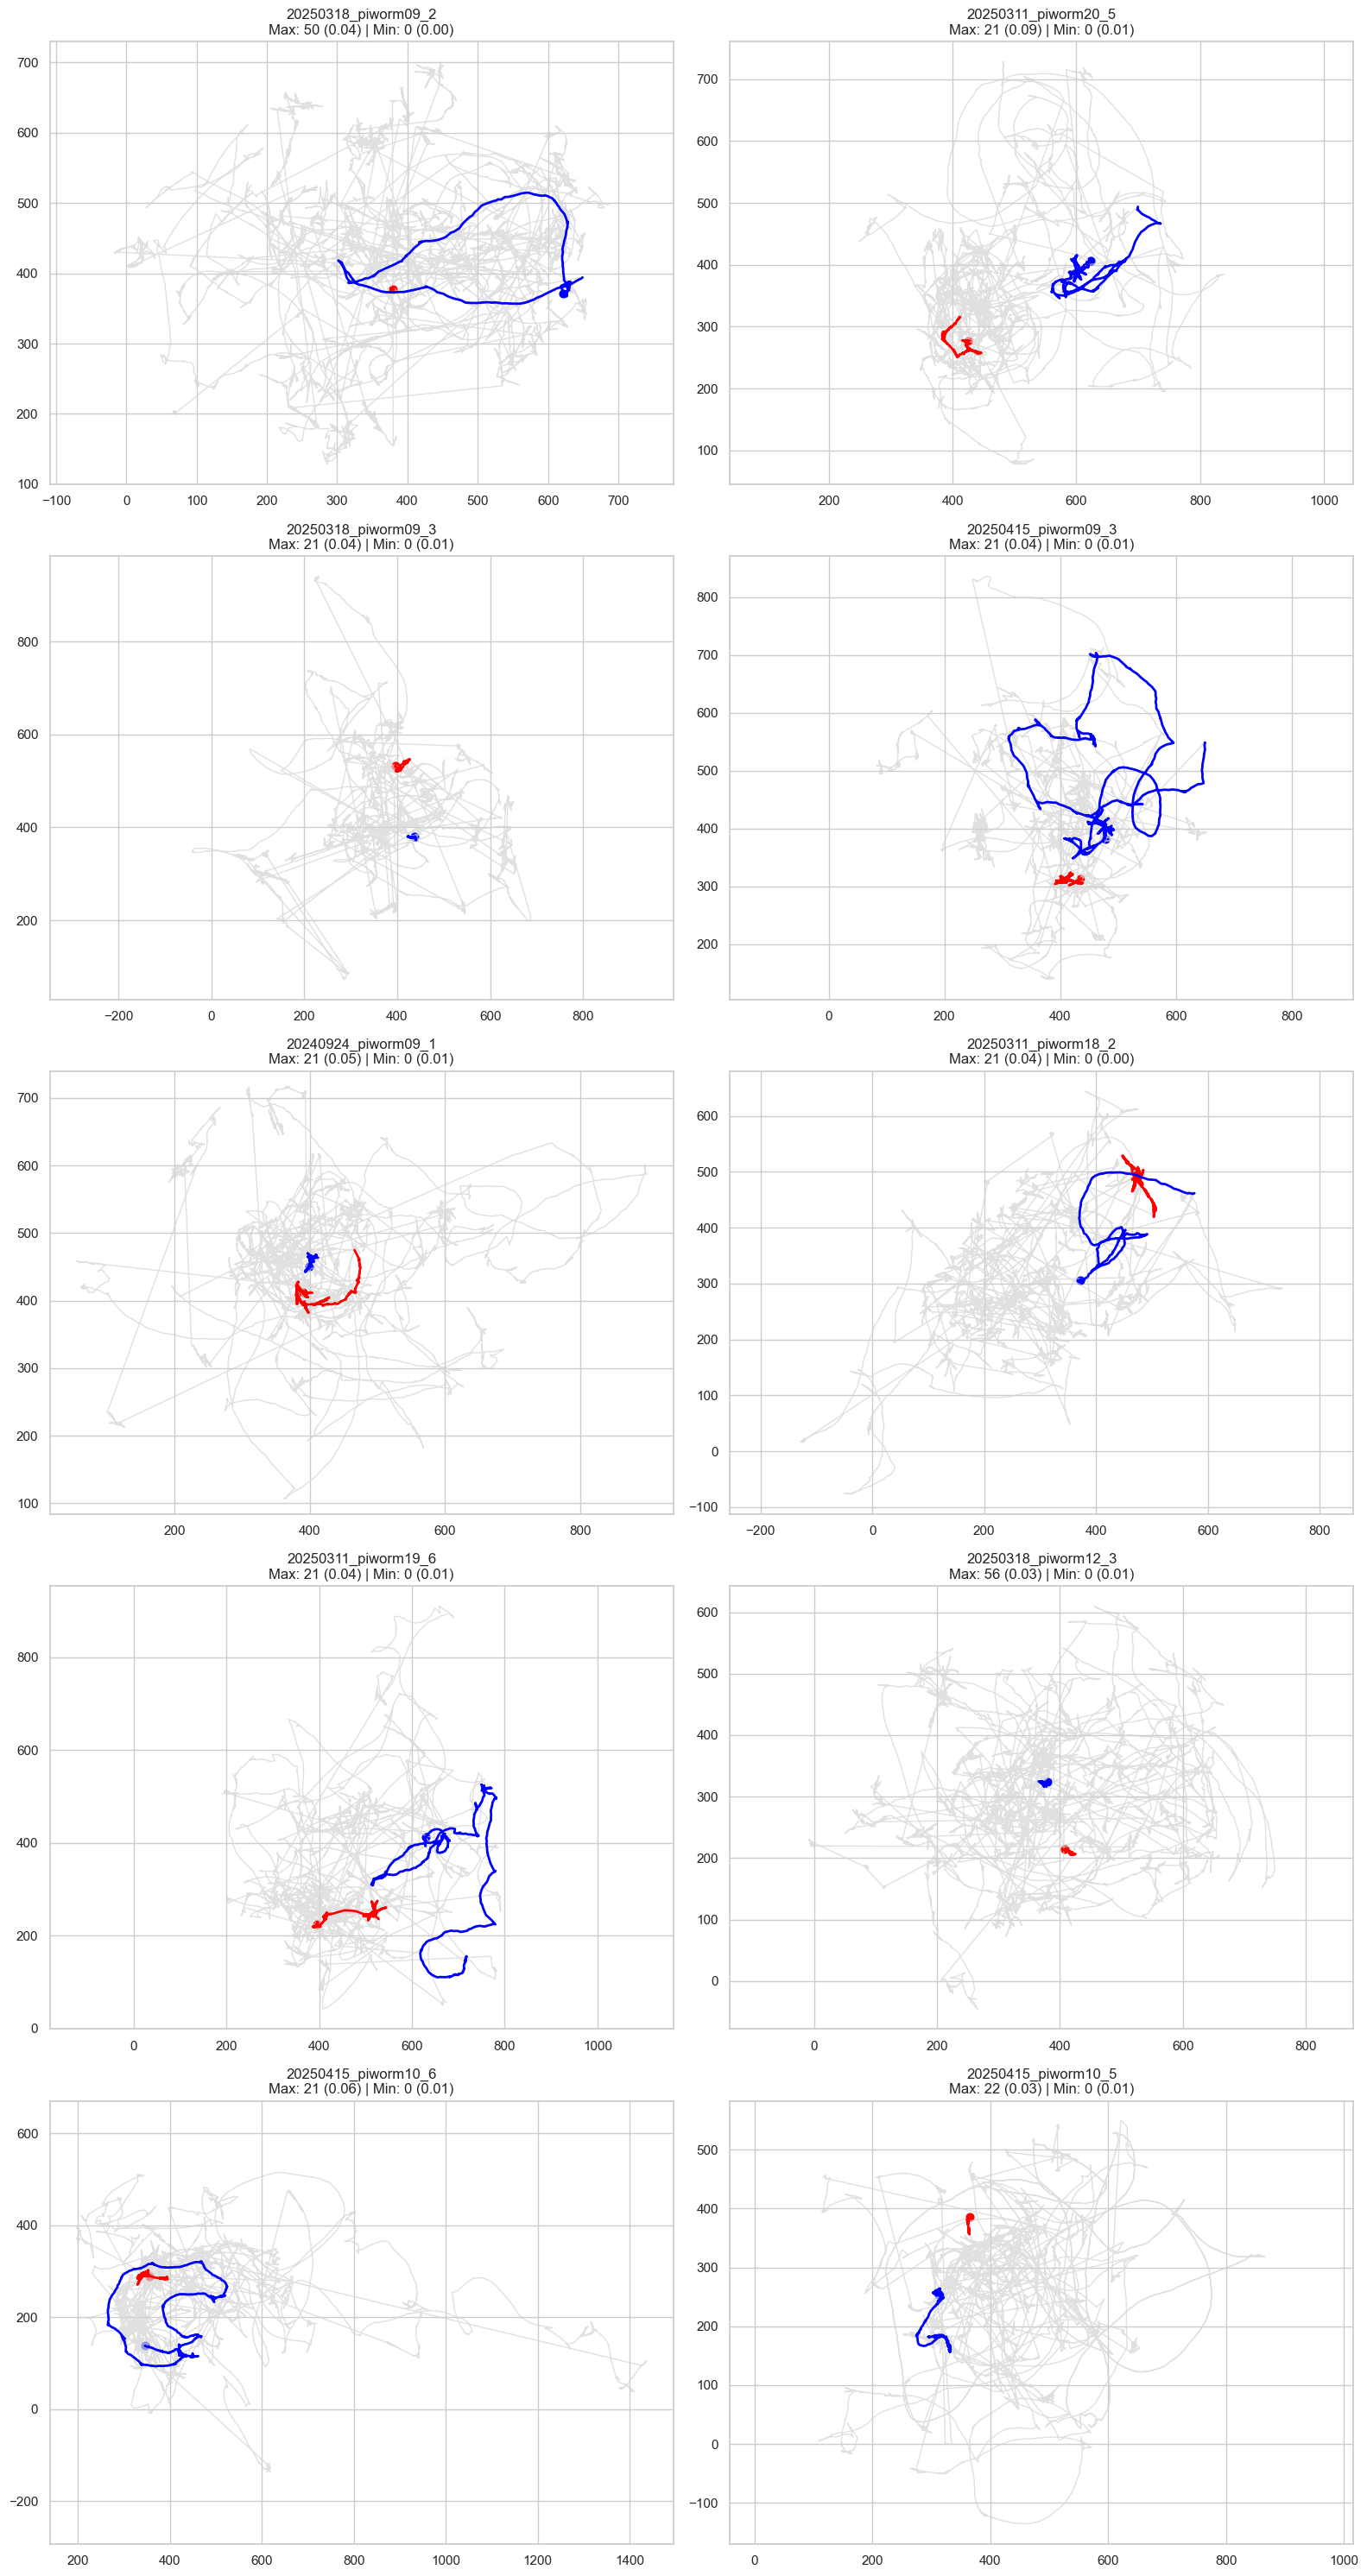

In [8]:
# --- Visualisation des Trajectoires ---
import random
import pandas as pd

def plot_worm_trajectories(indices, highlight_best_segment=True):
    """
    Affiche les trajectoires (X, Y) pour une liste d'indices de vers.
    Si highlight_best_segment est True, le segment avec la plus forte attention temporelle est mis en évidence (rouge),
    et celui avec la plus faible attention est mis en évidence (bleu).
    """
    n_worms = len(indices)
    cols = 2
    rows = (n_worms + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, rows*6))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        ax = axes[i]
        
        # 1. Récupération des données brutes (CSV) pour la trajectoire
        # dataset est un ScaledDataset, dataset.dataset est le UnifiedCElegansDataset
        file_path = dataset.dataset.pytorch_files[idx]
        worm_id = dataset.dataset.get_worm_ids_for_pytorch()[idx]
        
        df = pd.read_csv(file_path)
        
        # Plot de toute la trajectoire
        ax.plot(df['X'], df['Y'], color='lightgray', alpha=0.7, linewidth=1, label='Trajectoire')
        
        # 2. Identification du segment à mettre en évidence
        highlight_seg_idx = -1
        low_seg_idx = -1
        max_att = 0.0
        min_att = 0.0
        
        if highlight_best_segment:
            # On fait passer le ver dans le modèle pour avoir les attentions
            X_scaled, y = dataset[idx]
            
            # Détection du padding pour ne pas le sélectionner comme min
            is_padding = (X_scaled.abs().sum(dim=(1, 2)) == 0).numpy()
            
            X_input = X_scaled.unsqueeze(0).to(DEVICE)
            
            with torch.no_grad():
                _, t_weights, _ = model(X_input)
            
            # t_weights: (1, T, 1) -> (T,)
            t_att = t_weights.squeeze().cpu().numpy()
            
            # Trouver l'index du segment avec l'attention max
            highlight_seg_idx = np.argmax(t_att)
            max_att = t_att[highlight_seg_idx]
            
            # Trouver l'index du segment avec l'attention min (en ignorant le padding)
            t_att_masked = t_att.copy()
            t_att_masked[is_padding] = np.inf # On met l'attention du padding à l'infini pour l'exclure du min
            
            # S'il n'y a que du padding (cas impossible normalement), on prend argmin classique
            if np.all(np.isinf(t_att_masked)):
                 low_seg_idx = np.argmin(t_att)
            else:
                 low_seg_idx = np.argmin(t_att_masked)
                 
            min_att = t_att[low_seg_idx]
            
            ax.set_title(f"{worm_id}\nMax: {highlight_seg_idx} ({max_att:.2f}) | Min: {low_seg_idx} ({min_att:.2f})", fontsize=12)
        else:
            ax.set_title(f"{worm_id}", fontsize=12)

        # 3. Mise en évidence des segments
        unique_segments = sorted(df['Segment'].unique())
        
        # Segment Max Attention (Rouge)
        if highlight_seg_idx != -1 and highlight_seg_idx < len(unique_segments):
            seg_id = unique_segments[highlight_seg_idx]
            seg_df = df[df['Segment'] == seg_id]
            
            ax.plot(seg_df['X'], seg_df['Y'], color='red', linewidth=2, label='Max Att')
            if not seg_df.empty:
                ax.scatter(seg_df['X'].iloc[0], seg_df['Y'].iloc[0], color='red', s=40)

        # Segment Min Attention (Bleu)
        if low_seg_idx != -1 and low_seg_idx < len(unique_segments):
            seg_id = unique_segments[low_seg_idx]
            seg_df = df[df['Segment'] == seg_id]
            
            ax.plot(seg_df['X'], seg_df['Y'], color='blue', linewidth=2, label='Min Att')
            if not seg_df.empty:
                ax.scatter(seg_df['X'].iloc[0], seg_df['Y'].iloc[0], color='blue', s=40)
            
        ax.axis('equal')
        # ax.legend(fontsize='x-small')

    # Masquer les axes vides
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()

# Sélection de 10 vers aléatoires (5 positifs, 5 négatifs)
n_samples = 5
selected_indices = []

# Positifs
if len(pos_indices) >= n_samples:
    selected_indices.extend(random.sample(pos_indices, n_samples))
else:
    selected_indices.extend(pos_indices)

# Négatifs
if len(neg_indices) >= n_samples:
    selected_indices.extend(random.sample(neg_indices, n_samples))
else:
    selected_indices.extend(neg_indices)

# Compléter si nécessaire
while len(selected_indices) < 10 and len(selected_indices) < len(dataset):
    remaining = list(set(range(len(dataset))) - set(selected_indices))
    if remaining:
        selected_indices.append(random.choice(remaining))

print(f"Affichage des trajectoires pour {len(selected_indices)} vers...")
plot_worm_trajectories(selected_indices, highlight_best_segment=True)